In [1]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install lime

%cd /content/drive/MyDrive/msc_thesis

Mounted at /content/drive
/content/drive/MyDrive/msc_thesis


In [2]:
%run 'common_functions.ipynb'

In [55]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [56]:
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import ast
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import warnings
from sklearn.feature_selection import chi2
from sklearn import pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedGroupKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import manifold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, classification_report
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from xgboost import XGBClassifier
# from ipynb.fs.full.common_functions import  model_eval, import_data, find_index, eval_results, lime_explainer
# import lime
from glob import glob
from collections import defaultdict
import copy
import random

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.options.display.max_colwidth = 300

In [4]:
DOWNSAMPLING_RATIO = 0.1
TEXT_COLUMN = 'meas_action_comment_concat_3m_lemmas_string'
CLEANED_TEXT_COLUMN = 'cleaned_text'
GPT_REFINED_TEXT_COLUMN = 'gpt_refined_text'
TARGET_COLUMN = 'target'
ACCOUNT_ID = 'account_id'
SNAPNUM = 'snapnum'
DEDUPLICATED = 'deduplicated'
TRAIN_DATA = 'train_data'
VALIDATION_DATA = 'validation_data'
TEST_DATA = 'test_data'
NEGATIVE_DOWNSAMPLED = 'neg_downsampled'
GREEK_BERT = 'greek_bert'
TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TRAIN_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{VALIDATION_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
TEST_DATA_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TEST_DATA}.csv'
TEST_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TEST_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'

In [5]:
train_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
validation_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
test_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}', lineterminator='\n')

## Random Forest with TF-IDF and SMOTE

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Use TfidfVectorizer with n-grams
tfidf_vect = TfidfVectorizer(ngram_range=(2, 3))  # This includes bigrams and trigrams
X_train_tfidf = tfidf_vect.fit_transform(train_data[TEXT_COLUMN])
X_test_tfidf = tfidf_vect.transform(test_data[TEXT_COLUMN])

# Continue with SMOTE and classifier as before
smote = SMOTE(random_state=12, sampling_strategy=0.2)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, train_data[TARGET_COLUMN])

# Define the classifier
rf_clf_bow = RandomForestClassifier(random_state=34, class_weight={0: 1, 1:1000})
rf_clf_bow.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight={0: 1, 1: 1000}, random_state=34)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

true_labels = test_data[TARGET_COLUMN].ravel()
predictions =  rf_clf_bow.predict(X_test_tfidf)
# Predict probabilities for PR-AUC and R-Precision
predicted_probs = rf_clf_bow.predict_proba(X_test_tfidf)[:, 1]

# Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(true_labels, predictions, average='binary')  # adjust 'average' as needed
print(f"Precision: {precision}")

# Recall
recall = recall_score(true_labels, predictions, average='binary')  # adjust 'average' as needed
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(true_labels, predictions, average='binary')  # adjust 'average' as needed
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

# Get the indices that would sort the predicted probabilities in descending order
sorted_indices = np.argsort(predicted_probs)[::-1]

# Calculate Precision@20
top_20_true = true_labels[sorted_indices[:20]]
# Precision@20 = (# of true positives in top 20) / 20
precision_at_20 = np.mean(top_20_true)
print(f"Precision@20: {precision_at_20}")

# Calculate Recall@20
top_20_true = true_labels[sorted_indices[:20]]
num_positives = np.sum(true_labels)
recall_at_20 = np.sum(top_20_true) / num_positives
print(f"Recall@20: {recall_at_20}")


# Calculate R-Precision
num_positive_samples = np.sum(true_labels)
top_r_true = true_labels[sorted_indices[:num_positive_samples]]
r_precision = np.mean(top_r_true)
print(f"R-Precision: {r_precision}")

# Calculate PR-AUC
pr_auc = average_precision_score(true_labels, predicted_probs)
print(f"PR-AUC: {pr_auc}")

<ipython-input-14-35c874e080ec>:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  true_labels = test_data[TARGET_COLUMN].ravel()


Accuracy: 0.9391010752200859
Precision: 0.013513513513513514
Recall: 0.208955223880597
F1 Score: 0.025385312783318223
Confusion Matrix:
[[82816  5110]
 [  265    70]]
Precision@20: 0.0
Recall@20: 0.0
R-Precision: 0.008955223880597015
PR-AUC: 0.0075780269863999425


## BoW with Chi-squared feature selection for most important words

In [6]:
vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(train_data[TEXT_COLUMN])

X_test_bow = vectorizer.transform(test_data[TEXT_COLUMN])

In [7]:
X_train_vocab = vectorizer.get_feature_names_out()
p_value_limit = 0.95

chi2_stats, p = chi2(X_train_bow, train_data[TARGET_COLUMN])
text_features = pd.DataFrame({"feature":X_train_vocab, "score":1-p})
text_features = text_features.sort_values("score", ascending=False)
text_features = text_features[text_features["score"]>p_value_limit]

X_train_vocab = text_features["feature"].unique().tolist()

In [8]:
print("Number of selected features:", len(text_features))
print("Top features:", ",".join(text_features["feature"].values[:10]))

Number of selected features: 4471
Top features: 00,διπλασιασω,email,σημερα,βιωσιμη,σθυνολο,διπλασιαστει,σιγουρεψει,ektoσ,εξηγω


In [8]:
vectorizer = CountVectorizer(vocabulary=X_train_vocab)

X_train_bow = vectorizer.fit_transform(train_data[TEXT_COLUMN])

X_test_bow = vectorizer.transform(test_data[TEXT_COLUMN])

In [9]:
dic_vocabulary = vectorizer.vocabulary_

In [10]:
X_train_bow_df_init = pd.DataFrame(X_train_bow.toarray())
X_train_bow_df_init.columns = vectorizer.get_feature_names_out()

X_test_bow_df_init = pd.DataFrame(X_test_bow.toarray())
X_test_bow_df_init.columns = vectorizer.get_feature_names_out()

In [11]:
X_train_reduced = train_data.drop(columns=[TEXT_COLUMN])

X_train_bow_df = pd.concat([X_train_reduced.reset_index(drop=True), X_train_bow_df_init.reset_index(drop=True)], axis=1)

In [12]:
y_train = train_data[TARGET_COLUMN].reset_index(drop=True)

In [13]:
X_test_reduced = test_data.drop(columns=[TEXT_COLUMN])

X_test_bow_df = pd.concat([X_test_reduced.reset_index(drop=True), X_test_bow_df_init.reset_index(drop=True)], axis=1)

In [14]:
y_test = test_data[TARGET_COLUMN].reset_index(drop=True)

In [16]:
y_train.shape

(51366,)

In [15]:
X_train_bow_df_fin = X_train_bow_df.drop(columns=[ACCOUNT_ID,SNAPNUM])

X_test_bow_df_fin = X_test_bow_df.drop(columns=[ACCOUNT_ID,SNAPNUM])

In [18]:
X_train_bow_df_fin.head(5)

,target,00,διπλασιασω,email,σημερα,βιωσιμη,σθυνολο,διπλασιαστει,σιγουρεψει,ektoσ,...,εδρα,φιλος,σκεψη,επανκληση,προσκομιω,διαγραφει,cepal,εβαλε,απων,ποιος
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_train_bow_df_fin.shape

(51366, 4472)

In [17]:
X_test_bow_df_fin.shape

(88261, 4472)

In [22]:
nb_clf_bow = MultinomialNB()

tree_clf_bow = DecisionTreeClassifier(random_state=32)

svc_clf_bow = SVC(probability=True, random_state=33)

rf_clf_bow = RandomForestClassifier(random_state=34)

xgb_clf_bow = XGBClassifier(random_state=35)

ada_clf_bow = AdaBoostClassifier(random_state=36)



models = []
models.append(('MNB',  nb_clf_bow))
models.append(('SVC', svc_clf_bow))
models.append(('ABC',  ada_clf_bow))
models.append(('DT',  tree_clf_bow))
models.append(('RF',  rf_clf_bow))
models.append(('XGB',  xgb_clf_bow))

In [32]:
y_test.shape

(88261,)

In [50]:
X_train_bow_df_init.shape

(51366, 4471)

In [34]:
results_bow_init, models_bow_init = eval_results(models, X_train_bow_df_init, y_train, X_test_bow_df_init, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [38]:
results_bow_init

defaultdict(dict,
            {'MNB': {'accuracy': 0.8664868968173939,
              'recall': 0.4537313432835821,
              'precision': 0.012932868203862843,
              'f1_score': 0.02514890800794176,
              'predictions': array([0, 0, 0, ..., 1, 0, 0]),
              'probs': array([2.19166208e-02, 3.85263510e-05, 2.16146722e-05, ...,
                     7.82009492e-01, 6.19761547e-06, 3.76001784e-03]),
              'precision_at_20': 0.0,
              'recall_at_20': 0.0,
              'r_precision': 0.06567164179104477,
              'pr_auc': 0.018992018395355845},
             'SVC': {'accuracy': 0.9962950793668778,
              'recall': 0.03283582089552239,
              'precision': 0.7857142857142857,
              'f1_score': 0.06303724928366762,
              'predictions': array([0, 0, 0, ..., 0, 0, 0]),
              'probs': array([0.03635197, 0.03501725, 0.03354015, ..., 0.02508918, 0.02155266,
                     0.03568113]),
              'precis

## Normalization of the BoW features

In [18]:
normalizer1 = Normalizer()
X_train_bow_df_init_norm = normalizer1.fit_transform(X_train_bow_df_init)
X_test_bow_df_init_norm = normalizer1.transform(X_test_bow_df_init)

In [22]:
svc_clf_bow_norm = SVC(probability=True, random_state=42)

models = []
models.append(('SVC', svc_clf_bow_norm))

In [ ]:
results_bow_norm = defaultdict(dict)

# The expanding data split of train/test begins at position 5447 and will repeat for 20 time steps, until we predict the last
# day's target


for model in models:
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    rec_1, prec_1, f1_1, accuracy, pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(model[1], X_train_bow_df_init_norm, y_train, X_test_bow_df_init_norm, y_test)


    results_bow_norm[model[0]] = {'accuracy':[], 'recall':[], 'precision':[], 'f1_score':[], 'pr_auc':[], 'precision_at_k':[], 'recall_at_k':[], 'r_precision':[]}
    results_bow_norm[model[0]]['accuracy'] = accuracy
    results_bow_norm[model[0]]['recall'] = rec_1
    results_bow_norm[model[0]]['precision'] = prec_1
    results_bow_norm[model[0]]['f1_score'] = f1_1
    results_bow_norm[model[0]]['pr_auc'] = pr_auc
    results_bow_norm[model[0]]['precision_at_k'] = precision_at_k
    results_bow_norm[model[0]]['recall_at_k'] = recall_at_k
    results_bow_norm[model[0]]['r_precision'] = r_precision

In [ ]:
results_bow_norm

## Normalization of the BoW features and class weights

In [19]:
weights = {0:1, 1:5}

# svc_clf_bow_norm_weight = SVC(probability=True, random_state=42, class_weight=weights)

rf_clf_bow_norm_weight = RandomForestClassifier(random_state=43, class_weight=weights)

xgb_clf_norm_weight = XGBClassifier(random_state=45, class_weight=weights)

models = []
# models.append(('SVC', svc_clf_bow_norm_weight))
models.append(('RF',  rf_clf_bow_norm_weight))
models.append(('XGB',  xgb_clf_norm_weight))

results_bow_norm_weight = defaultdict(dict)

for model in models:
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    rec_1, prec_1, f1_1, accuracy, pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(model[1], X_train_bow_df_init_norm, y_train, X_test_bow_df_init_norm, y_test)


    results_bow_norm_weight[model[0]] = {'accuracy':[], 'recall':[], 'precision':[], 'f1_score':[]}
    results_bow_norm_weight[model[0]]['accuracy'] = accuracy
    results_bow_norm_weight[model[0]]['recall'] = rec_1
    results_bow_norm_weight[model[0]]['precision'] = prec_1
    results_bow_norm_weight[model[0]]['f1_score'] = f1_1
    results_bow_norm_weight[model[0]]['pr_auc'] = pr_auc
    results_bow_norm_weight[model[0]]['precision_at_k'] = precision_at_k
    results_bow_norm_weight[model[0]]['recall_at_k'] = recall_at_k
    results_bow_norm_weight[model[0]]['r_precision'] = r_precision

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [20]:
results_bow_norm_weight

defaultdict(dict,
            {'RF': {'accuracy': 0.992034987140413,
              'recall': 0.16417910447761194,
              'precision': 0.11506276150627615,
              'f1_score': 0.13530135301353013,
              'pr_auc': 0.08152561832029738,
              'precision_at_k': 0.5,
              'recall_at_k': 0.029850746268656716,
              'r_precision': 0.1582089552238806},
             'XGB': {'accuracy': 0.9947428649120224,
              'recall': 0.13432835820895522,
              'precision': 0.2054794520547945,
              'f1_score': 0.1624548736462094,
              'pr_auc': 0.08891693073254008,
              'precision_at_k': 0.6,
              'recall_at_k': 0.03582089552238806,
              'r_precision': 0.16119402985074627}})

We will repeat the same methodology using n_grams (1,3). We will first train and evaluate on non-normalized data, then we will normalize, and then we will also use class weights on the normalized data.

## N-grams with $\chi^2$ feature selection

In [21]:
vectorizer_n_grams = CountVectorizer(vocabulary=X_train_vocab, ngram_range=(1,3))

X_train_n_grams = vectorizer_n_grams.fit_transform(train_data[TEXT_COLUMN])
X_train_n_grams_df_init = pd.DataFrame(X_train_n_grams.toarray())
X_train_n_grams_df_init.columns = vectorizer_n_grams.get_feature_names_out()

X_test_n_grams = vectorizer_n_grams.transform(test_data[TEXT_COLUMN])
X_test_n_grams_df_init = pd.DataFrame(X_test_n_grams.toarray())
X_test_n_grams_df_init.columns = vectorizer_n_grams.get_feature_names_out()

In [22]:
X_train_n_grams_df = pd.concat([X_train_reduced.reset_index(drop=True), X_train_n_grams_df_init.reset_index(drop=True)], \
                           axis=1)

X_test_n_grams_df = pd.concat([X_test_reduced.reset_index(drop=True), X_test_n_grams_df_init.reset_index(drop=True)], \
                           axis=1)

X_train_n_grams_df_fin = X_train_n_grams_df.drop(columns=[ACCOUNT_ID,SNAPNUM,TARGET_COLUMN])

X_test_n_grams_df_fin = X_test_n_grams_df.drop(columns=[ACCOUNT_ID,SNAPNUM,TARGET_COLUMN])

In [23]:
X_train_n_grams_df_fin.fillna(0, inplace=True)
X_test_n_grams_df_fin.fillna(0, inplace=True)

In [24]:
X_train_n_grams_df_fin.shape

(51366, 4471)

In [25]:
nb_clf_ng = MultinomialNB()

# tree_clf_ng = DecisionTreeClassifier(random_state=12)

# svc_clf_ng = SVC(probability=True, random_state=13)

rf_clf_ng = RandomForestClassifier(random_state=14)

xgb_clf_ng = XGBClassifier(random_state=15)

# ada_clf_ng = AdaBoostClassifier(random_state=16)


models = []
models.append(('MNB',  nb_clf_ng))
# models.append(('SVC', svc_clf_ng))
# models.append(('ABC',  ada_clf_ng))
# models.append(('DT',  tree_clf_ng))
models.append(('RF',  rf_clf_ng))
models.append(('XGB',  xgb_clf_ng))

In [26]:
results_n_grams = defaultdict(dict)

# The expanding data split of train/test begins at position 5447 and will repeat for 20 time steps, until we predict the last
# day's target


for model in models:
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    rec_1, prec_1, f1_1, accuracy, pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(model[1], X_train_n_grams_df_fin, y_train, X_test_n_grams_df_fin, y_test)


    results_n_grams[model[0]] = {'accuracy':[], 'recall':[], 'precision':[], 'f1_score':[], 'pr_auc':[], 'precision_at_k':[], 'recall_at_k':[], 'r_precision':[]}
    results_n_grams[model[0]]['accuracy'] = accuracy
    results_n_grams[model[0]]['recall'] = rec_1
    results_n_grams[model[0]]['precision'] = prec_1
    results_n_grams[model[0]]['f1_score'] = f1_1
    results_n_grams[model[0]]['pr_auc'] = pr_auc
    results_n_grams[model[0]]['precision_at_k'] = precision_at_k
    results_n_grams[model[0]]['recall_at_k'] = recall_at_k
    results_n_grams[model[0]]['r_precision'] = r_precision

In [27]:
results_n_grams

defaultdict(dict,
            {'MNB': {'accuracy': 0.8664868968173939,
              'recall': 0.4537313432835821,
              'precision': 0.012932868203862843,
              'f1_score': 0.02514890800794176,
              'pr_auc': 0.018992018395355845,
              'precision_at_k': 0.0,
              'recall_at_k': 0.0,
              'r_precision': 0.06567164179104477},
             'RF': {'accuracy': 0.9952187262777444,
              'recall': 0.1701492537313433,
              'precision': 0.2835820895522388,
              'f1_score': 0.2126865671641791,
              'pr_auc': 0.1098318977712869,
              'precision_at_k': 0.55,
              'recall_at_k': 0.03283582089552239,
              'r_precision': 0.1791044776119403},
             'XGB': {'accuracy': 0.9948674952697114,
              'recall': 0.1582089552238806,
              'precision': 0.23660714285714285,
              'f1_score': 0.18962432915921287,
              'pr_auc': 0.08691627858800535,
             

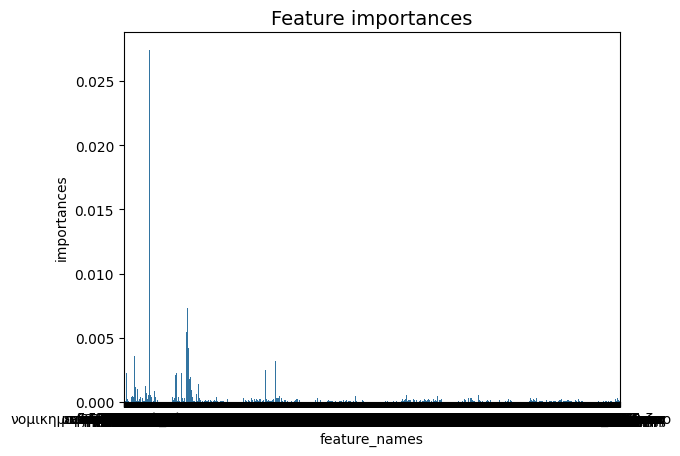

In [28]:
# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : rf_clf_ng.feature_names_in_,
                               "importances" : rf_clf_ng.feature_importances_})

# Plotting bar chart, g is from graph
g = sns.barplot(x=importances_df["feature_names"],
                y=importances_df["importances"])
g.set_title("Feature importances", fontsize=14);

In [29]:
importances_df.sort_values(by=['importances'],ascending=False).head(20)

,feature_names,importances
231,δα,0.027402
584,xxxxς,0.018269
28,σε,0.012142
163,τηλεφωνο,0.011190
365,απο,0.010809
386,μηνυμα,0.009563
170,δεν,0.008966
4427,τηλεφωνητησ,0.008495
450,με,0.008118
310,κατοχοσ,0.007742


In [ ]:
describe_df = X_train_n_grams_df_fin.describe()

In [ ]:
describe_df.iloc[1].sort_values(ascending=False)

## Normalization of the N-grams

In [ ]:
normalizer2 = Normalizer()
X_train_n_grams_df_fin_norm = normalizer2.fit_transform(X_train_n_grams_df_fin)
X_test_n_grams_df_fin_norm = normalizer2.transform(X_test_n_grams_df_fin)

In [ ]:
nb_clf_ng_norm = MultinomialNB()

# tree_clf_ng_norm = DecisionTreeClassifier(random_state=22)

# svc_clf_ng_norm = SVC(probability=True, random_state=23)

rf_clf_ng_norm = RandomForestClassifier(random_state=24)

xgb_clf_ng_norm = XGBClassifier(random_state=25)

# ada_clf_ng_norm = AdaBoostClassifier(random_state=26)



models = []
models.append(('MNB',  nb_clf_ng_norm))
# models.append(('SVC', svc_clf_ng_norm))
# models.append(('ABC',  ada_clf_ng_norm))
# models.append(('DT',  tree_clf_ng_norm))
models.append(('RF',  rf_clf_ng_norm))
models.append(('XGB',  xgb_clf_ng_norm))

In [ ]:
results_ng_norm = defaultdict(dict)

# The expanding data split of train/test begins at position 5447 and will repeat for 20 time steps, until we predict the last
# day's target


for model in models:
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    rec, prec, f1_score, acc,  pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(model[1], X_train_n_grams_df_fin_norm, y_train, X_test_n_grams_df_fin_norm, y_test)


    results_ng_norm[model[0]] = {'accuracy':[], 'recall':[], 'precision':[], 'f1_score':[]}
    results_ng_norm[model[0]]['accuracy'] = acc
    results_ng_norm[model[0]]['recall'] = rec
    results_ng_norm[model[0]]['precision'] = prec
    results_ng_norm[model[0]]['f1_score'] = f1_score
    results_ng_norm[model[0]]['pr_auc'] = pr_auc
    results_ng_norm[model[0]]['precision_at_k'] = precision_at_k
    results_ng_norm[model[0]]['recall_at_k'] = recall_at_k
    results_ng_norm[model[0]]['r_precision'] = r_precision

In [ ]:
results_ng_norm

## N-grams and class weights

In [31]:
weights = {0:1, 1:5}

# tree_clf_ng_norm_weight = DecisionTreeClassifier(random_state=61, class_weight=weights)

# svc_clf_ng_norm_weight = SVC(probability=True, random_state=62, class_weight=weights)

rf_clf_ng_weight = RandomForestClassifier(random_state=63, class_weight=weights)

xgb_clf_ng_weight = XGBClassifier(random_state=65, class_weight=weights)

models = []
models.append(('RF',  rf_clf_ng_weight))
models.append(('XGB',  xgb_clf_ng_weight))

results_ng_weight = defaultdict(dict)


for model in models:
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    rec, prec, f1_score, acc, pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(model[1], X_train_n_grams_df_fin, y_train, X_test_n_grams_df_fin, y_test)


    results_ng_weight[model[0]] = {'accuracy':[], 'recall':[], 'precision':[], 'f1_score':[]}
    results_ng_weight[model[0]]['accuracy'] = acc
    results_ng_weight[model[0]]['recall'] = rec
    results_ng_weight[model[0]]['precision'] = prec
    results_ng_weight[model[0]]['f1_score'] = f1_score
    results_ng_weight[model[0]]['pr_auc'] = pr_auc
    results_ng_weight[model[0]]['precision_at_k'] = precision_at_k
    results_ng_weight[model[0]]['recall_at_k'] = recall_at_k
    results_ng_weight[model[0]]['r_precision'] = r_precision

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [32]:
results_ng_weight

defaultdict(dict,
            {'RF': {'accuracy': 0.9934852313026138,
              'recall': 0.17313432835820897,
              'precision': 0.16292134831460675,
              'f1_score': 0.1678726483357453,
              'pr_auc': 0.09504888808744556,
              'precision_at_k': 0.55,
              'recall_at_k': 0.03283582089552239,
              'r_precision': 0.17313432835820897},
             'XGB': {'accuracy': 0.9948674952697114,
              'recall': 0.1582089552238806,
              'precision': 0.23660714285714285,
              'f1_score': 0.18962432915921287,
              'pr_auc': 0.08691627858800535,
              'precision_at_k': 0.5,
              'recall_at_k': 0.029850746268656716,
              'r_precision': 0.1880597014925373}})

## Averaged Word2Vec Embeddings for Text Classification with XGBoost

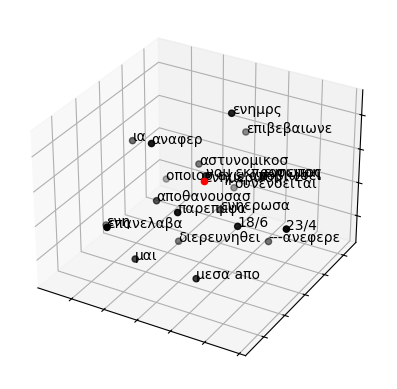

In [34]:
corpus = train_data[TEXT_COLUMN]

# Create list of lists of tokens (unigrams)
lst_corpus = [row.split() for row in corpus]

# Detect bigrams
bigrams_detector = gensim.models.Phrases(lst_corpus, min_count=5, threshold=10, delimiter=' ')
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

# Apply bigrams detector to corpus
lst_corpus = [bigrams_detector[sent] for sent in lst_corpus]

# Detect trigrams on the bigram-transformed corpus
trigrams_detector = gensim.models.Phrases(lst_corpus, min_count=5, threshold=10, delimiter=' ')
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

# Apply trigrams detector to corpus
lst_corpus = [trigrams_detector[sent] for sent in lst_corpus]

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(
    lst_corpus,
    vector_size=300,
    window=8,
    min_count=1,
    sg=1,
    workers=4
)

word = "ενημερωση"  # a random anchor word
fig = plt.figure()

# Get the top 20 most similar words with the anchor
similar_words = [tup[0] for tup in word2vec_model.wv.most_similar(word, topn=20)]
tot_words = [word] + similar_words

# Extract the word vectors
X = word2vec_model.wv[tot_words]

# Use t-SNE to reduce dimensionality from 300 to 3
tsne = manifold.TSNE(perplexity=10, n_components=3, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the 3D coordinates
dtf_ = pd.DataFrame(X_tsne, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_.at[word, "input"] = 1  # Mark the input word

# Plot in 3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'],
           dtf_[dtf_["input"]==0]['y'],
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'],
           dtf_[dtf_["input"]==1]['y'],
           dtf_[dtf_["input"]==1]['z'], c="red")

ax.set(xlabel=None, ylabel=None, zlabel=None,
       xticklabels=[], yticklabels=[], zticklabels=[])

for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

plt.show()

In [35]:
def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if not word_vectors:  # If the text is empty or contains only unknown words, return a zero vector
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)

# Assume 'texts' is a list of strings (your text data)
train_feature_vectors = pd.DataFrame(np.array([text_to_vector(text, word2vec_model) for text in train_data[TEXT_COLUMN].to_list()]))
test_feature_vectors = pd.DataFrame(np.array([text_to_vector(text, word2vec_model) for text in test_data[TEXT_COLUMN].to_list()]))

In [36]:
X_train_word2vec_df = pd.concat([X_train_reduced.reset_index(drop=True), train_feature_vectors.reset_index(drop=True)], axis=1).drop(columns=[ACCOUNT_ID, SNAPNUM, TARGET_COLUMN])
X_test_word2vec_df = pd.concat([X_test_reduced.reset_index(drop=True), test_feature_vectors.reset_index(drop=True)], axis=1).drop(columns=[ACCOUNT_ID, SNAPNUM, TARGET_COLUMN])

X_train_word2vec_df.columns = X_train_word2vec_df.columns.astype(str)
X_test_word2vec_df.columns = X_test_word2vec_df.columns.astype(str)

In [37]:
# Train the logistic regression model
clf = XGBClassifier(random_state=45)
rec_1, prec_1, f1_1, accuracy, pr_auc, precision_at_k, recall_at_k, r_precision = model_eval(clf, X_train_word2vec_df, y_train, X_test_word2vec_df, y_test, K=20)

print("Recall: ", rec_1)
print("Precision: ", prec_1)
print("F1: ", f1_1)
print("Accuracy: ", accuracy)
print("PR AUC: ", pr_auc)
print("Precision at K: ", precision_at_k)
print("Recall at K: ", recall_at_k)
print("R Precision: ", r_precision)

Recall:  0.1761194029850746
Precision:  0.2027491408934708
F1:  0.18849840255591055
Accuracy:  0.9942443434812658
PR AUC:  0.07789003355961527
Precision at K:  0.35
Recall at K:  0.020895522388059702
R Precision:  0.1791044776119403


## Attention-Driven BiLSTM Text Classifier with Word2Vec Embeddings

In [38]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ',
                     oov_token="NaN",
                     filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train_seq_idx = kprocessing.sequence.pad_sequences(lst_text2seq,
                    maxlen=15, padding="post", truncating="post")

In [39]:
len(X_train_seq_idx)

51366

In [40]:
i = 5

## list of text: ["I like this", ...]
len_txt = len(train_data[TEXT_COLUMN].iloc[i].split())
print("from: ", train_data[TEXT_COLUMN].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train_seq_idx[i])
print("to: ", X_train_seq_idx[i], "| len:", len(X_train_seq_idx[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", train_data[TEXT_COLUMN].iloc[i].split()[0],
      " -- idx in vocabulary -->",
      dic_vocabulary[train_data[TEXT_COLUMN].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  ############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################## πapakaλoyme oπωσ eπikoinωnhσete ameσa με th δikhγopikh etaipeia g. l. o. σto thλ .

In [41]:
corpus = test_data[TEXT_COLUMN]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0,
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test_seq_idx = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [42]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word2vec_model.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [46]:
word = "ενημερωση"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape,
      "|vector")

dic[word]: 37 |idx
embeddings[idx]: (300,) |vector


In [57]:
# Prepare validation sequences
corpus = validation_data[TEXT_COLUMN].tolist()
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

# Apply bigram and trigram detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# Convert to sequences using the fitted tokenizer
lst_text2seq_val = tokenizer.texts_to_sequences(lst_corpus)

# Pad sequences
X_val_seq_idx = kprocessing.sequence.pad_sequences(lst_text2seq_val, maxlen=15,
                                                   padding="post", truncating="post")

# Extract y from validation_data
y_val = validation_data[TARGET_COLUMN].values.ravel()

In [58]:
def build_model():
    def attention_layer(inputs, neurons):
        x = layers.Permute((2,1))(inputs)
        x = layers.Dense(neurons, activation="softmax")(x)
        x = layers.Permute((2,1), name="attention")(x)
        x = layers.multiply([inputs, x])
        return x

    ## input
    x_in = layers.Input(shape=(15,))
    ## embedding
    x = layers.Embedding(input_dim=embeddings.shape[0],
                        output_dim=embeddings.shape[1],
                        weights=[embeddings],
                        input_length=15, trainable=False)(x_in)
    ## apply attention
    x = attention_layer(x, neurons=15)
    ## 2 layers of bidirectional lstm
    x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2,
                            return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
    ## final dense layers
    x = layers.Dense(64, activation='relu')(x)

    y_out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(x_in, y_out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def objective(trial):
    epochs = trial.suggest_int("epochs", 5, 30)

    # Suggest class weight for class '1'
    class_weight_1 = trial.suggest_float("class_weight_1", 1.0, 2000.0, log=True)
    class_weights = {0:1., 1:class_weight_1}

    # Build the model
    model = build_model()

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    # Train the model
    history = model.fit(
        X_train_seq_idx, y_train,
        batch_size=256,
        epochs=epochs,
        shuffle=True,
        verbose=0,
        validation_data=(X_val_seq_idx, y_val),
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

    # We can optimize on validation loss or validation accuracy.
    # Let's optimize based on the minimum validation loss during training.
    val_loss = min(history.history['val_loss'])
    return val_loss

# Run the Optuna study
study = optuna.create_study(direction="minimize")  # We want to minimize validation loss
study.optimize(objective, n_trials=10)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_epochs = best_trial.params["epochs"]
best_class_weight_1 = best_trial.params["class_weight_1"]

model = build_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
model.fit(
    X_train_seq_idx, y_train,
    batch_size=256,
    epochs=best_epochs,
    shuffle=True,
    verbose=0,
    validation_data=(X_val_seq_idx, y_val),
    class_weight={0:1., 1:best_class_weight_1},
    callbacks=[early_stopping]
)

[I 2024-12-10 21:09:02,267] A new study created in memory with name: no-name-6e9d90c3-b0ad-4769-8f75-6757c163de6c
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-10 21:09:46,099] Trial 0 finished with value: 0.1636297106742859 and parameters: {'epochs': 5, 'class_weight_1': 2.026298673364564}. Best is trial 0 with value: 0.1636297106742859.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-10 21:11:59,026] Trial 1 finished with value: 0.15249454975128174 and parameters: {'epochs': 27, 'class_weight_1': 1.0517073284543395}. Best is trial 1 with value: 0.15249454975128174.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 202

Best trial:
  Value: 0.15249454975128174
  Params: 
    epochs: 27
    class_weight_1: 1.0517073284543395


In [60]:
## test
predicted_prob = model.predict(X_test_seq_idx)
# Convert predictions to class labels
predicted = np.argmax(predicted_prob, axis=1)

# Basic metrics
y_true = y_test.values.ravel()
accuracy = accuracy_score(y_true, predicted)
report = classification_report(y_true, predicted, labels=[0, 1], target_names=["0", "1"], output_dict=True)
prec_1 = report["1"]["precision"]
rec_1 = report["1"]["recall"]
f1_1 = report["1"]["f1-score"]

# Ranking-based metrics
# Extract positive class probabilities
pos_prob = predicted_prob[:, 0]  # Extract the probability of the positive class

# Sort indices by predicted probability in descending order
sorted_indices = np.argsort(pos_prob)[::-1]

K = 20
top_k_true = y_true[sorted_indices[:K]]

# Precision@20
precision_at_20 = np.mean(top_k_true)

# Recall@20
num_positives = np.sum(y_true)
recall_at_20 = np.sum(top_k_true) / num_positives if num_positives > 0 else 0.0

# R-Precision
if num_positives > 0:
    top_r_true = y_true[sorted_indices[:num_positives]]
    r_precision = np.mean(top_r_true)
else:
    r_precision = 0.0

# PR-AUC
pr_auc = average_precision_score(y_true, pos_prob)

print(f"Precision@20: {precision_at_20}")
print(f"Recall@20: {recall_at_20}")
print(f"R-Precision: {r_precision}")
print(f"PR-AUC: {pr_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision (class 1): {prec_1}")
print(f"Recall (class 1): {rec_1}")
print(f"F1-Score (class 1): {f1_1}")

2759/2759 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
Precision@20: 0.1
Recall@20: 0.005970149253731343
R-Precision: 0.07164179104477612
PR-AUC: 0.023342665793600316
Accuracy: 0.9962044391067403
Precision (class 1): 0.0
Recall (class 1): 0.0
F1-Score (class 1): 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
